# Sample Lya posterior as a function of nuisance parameters

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import cProfile
import emcee
# our own modules
import simplest_emulator
import linear_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import lya_theory
import likelihood

### Setup Lya likelihood function

In [2]:
# read P1D measurement
data=data_PD2013.P1D_PD2013(blind_data=True)
zs=data.z

In [3]:
# load P1D emulator
emu=linear_emulator.LinearEmulator(verbose=False)

setup interpolator for coefficient 0
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-1.18323575]
setup interpolator for coefficient 1
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-0.6323589]
setup interpolator for coefficient 2
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-0.29370814]
setup interpolator for coefficient 3
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-0.1279153]
setup interpolator for coefficient 4
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-0.01945575]


In [4]:
# setup theory to predict Lya 1D power
theory = lya_theory.LyaTheory(zs,emulator=emu,verbose=False)
# for this simple test, just use fiducial cosmology
theory.set_cosmo_model(linP_model=theory.cosmo.linP_model_fid)
linP_Mpc_params=theory.cosmo.get_linP_Mpc_params()

Note: redshifts have been re-sorted (earliest first)


In [5]:
# specify free parameters in likelihood
#free_parameters=['ln_tau_0','ln_tau_1']
#free_parameters=['ln_tau_0','ln_tau_1','ln_T0_0']
#free_parameters=['ln_tau_0','ln_tau_1','ln_T0_0','ln_gamma_0']
free_parameters=['ln_tau_0','ln_tau_1','ln_T0_0','ln_T0_1','ln_gamma_0','ln_gamma_1']

In [6]:
like=likelihood.Likelihood(data=data,theory=theory,free_parameters=free_parameters,verbose=True)

likelihood setup with 6 free parameters
6 free parameters


In [7]:
for p in like.free_params:
    print(p.name,p.value)

ln_tau_0 -0.794580172414
ln_tau_1 3.18
ln_T0_0 9.21034037198
ln_T0_1 0.0
ln_gamma_0 0.336472236621
ln_gamma_1 0.0


In [8]:
like.go_silent()

### Setup MCMC to call this function

In [9]:
def log_prob(values,like,linP_Mpc_params,verbose=False):
    test_log_prob=like.log_prob(values=values,linP_Mpc_params=linP_Mpc_params)
    if np.isnan(test_log_prob):
        if verbose:
            print('parameter values outside hull',values)
        return -np.inf
    return test_log_prob

In [10]:
def setup_walkers(ndim,nwalkers,like,linP_Mpc_params,verbose=False):
    print('setup %d walkers with %d dimensions'%(nwalkers,ndim))
    p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
    # make sure that all walkers are within the convex hull
    for iw in range(nwalkers):
        walker=p0[iw]
        if verbose: print(iw,'walker',walker)
        test=log_prob(walker,like,linP_Mpc_params)
        while (test == -np.inf):
            if verbose: print(iw,'bad walker',walker)
            walker = np.random.rand(ndim)
            if verbose: print(iw,'try walker',walker)
            test=log_prob(walker,like,linP_Mpc_params)
        if verbose: print(iw,'good walker',walker,' log_prob=',test)
        p0[iw]=walker
    return p0

In [11]:
# for now we'll have only three dimensions (mean flux, temperature, gamma)
ndim=len(like.free_params)
# setup initial walkers
nwalkers = 20

In [12]:
p0=setup_walkers(ndim,nwalkers,like,linP_Mpc_params)
p0

setup 20 walkers with 6 dimensions


array([[ 0.31188818,  0.07714491,  0.68363555,  0.38829522,  0.71761535,
         0.65630603],
       [ 0.41497196,  0.95273911,  0.72204384,  0.44343492,  0.50675554,
         0.41528519],
       [ 0.36607077,  0.95882811,  0.32220802,  0.05456786,  0.41547579,
         0.16350138],
       [ 0.79421795,  0.76299446,  0.75645424,  0.44632138,  0.7809172 ,
         0.52959249],
       [ 0.03443134,  0.07511727,  0.51232393,  0.14051654,  0.7142663 ,
         0.41670038],
       [ 0.44995246,  0.57825329,  0.4890353 ,  0.51558457,  0.65856085,
         0.5692783 ],
       [ 0.81339141,  0.36423568,  0.63733231,  0.36678736,  0.66261055,
         0.68104658],
       [ 0.32692085,  0.61969087,  0.59973081,  0.41048782,  0.64166147,
         0.28105482],
       [ 0.36976322,  0.6706313 ,  0.67214432,  0.39610333,  0.84310941,
         0.56984064],
       [ 0.12493826,  0.94461701,  0.48879571,  0.33416227,  0.61352594,
         0.28984508],
       [ 0.91943895,  0.99515429,  0.47649296,  0.

In [13]:
# setup sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[like,linP_Mpc_params])

In [14]:
# burn-in phase
pos, prob, state = sampler.run_mcmc(p0, 100)
print('finished burn-in at',pos,prob)

finished burn-in at [[ 0.57272887  0.65731174  0.68004785  0.57023933  0.61163833  0.74805534]
 [ 0.54119704  0.69282943  0.69778925  0.56261577  0.60360628  0.72754929]
 [ 0.53132633  0.60897258  0.64891632  0.55064876  0.63784609  0.70705769]
 [ 0.56612809  0.6628689   0.67298481  0.59638674  0.6338444   0.71668824]
 [ 0.5945175   0.72055729  0.65376561  0.64536279  0.63473775  0.71154495]
 [ 0.58912823  0.63818443  0.66708306  0.62748098  0.62076675  0.77929223]
 [ 0.56728969  0.65453374  0.66178283  0.58070565  0.62971587  0.71758977]
 [ 0.52328888  0.57183118  0.63895647  0.55323197  0.67888805  0.69074778]
 [ 0.57921705  0.63367609  0.68927051  0.6250614   0.59251283  0.76520795]
 [ 0.51614576  0.59735195  0.64954218  0.54674234  0.66394663  0.69405581]
 [ 0.58406021  0.70997179  0.66646159  0.63612229  0.63258104  0.71014371]
 [ 0.57223226  0.61674013  0.63077107  0.57938051  0.64297429  0.72554072]
 [ 0.57058349  0.61624712  0.68221035  0.60162614  0.60494151  0.76092754]
 [ 0.

In [15]:
# reset and run actual chains
sampler.reset()
nsteps=500
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    if i % 100 == 0:
        print(i,result[0])

0 [[ 0.57272887  0.65731174  0.68004785  0.57023933  0.61163833  0.74805534]
 [ 0.5427331   0.70998104  0.71348364  0.56243248  0.5905876   0.73858673]
 [ 0.53132633  0.60897258  0.64891632  0.55064876  0.63784609  0.70705769]
 [ 0.56823585  0.64081301  0.67734924  0.5988654   0.62017099  0.73761702]
 [ 0.5945175   0.72055729  0.65376561  0.64536279  0.63473775  0.71154495]
 [ 0.58912823  0.63818443  0.66708306  0.62748098  0.62076675  0.77929223]
 [ 0.56728969  0.65453374  0.66178283  0.58070565  0.62971587  0.71758977]
 [ 0.52328888  0.57183118  0.63895647  0.55323197  0.67888805  0.69074778]
 [ 0.57921705  0.63367609  0.68927051  0.6250614   0.59251283  0.76520795]
 [ 0.53955383  0.60547682  0.6635894   0.57034222  0.63857459  0.72281047]
 [ 0.58406021  0.70997179  0.66646159  0.63612229  0.63258104  0.71014371]
 [ 0.57223226  0.61674013  0.63077107  0.57938051  0.64297429  0.72554072]
 [ 0.57058349  0.61624712  0.68221035  0.60162614  0.60494151  0.76092754]
 [ 0.58246575  0.662146

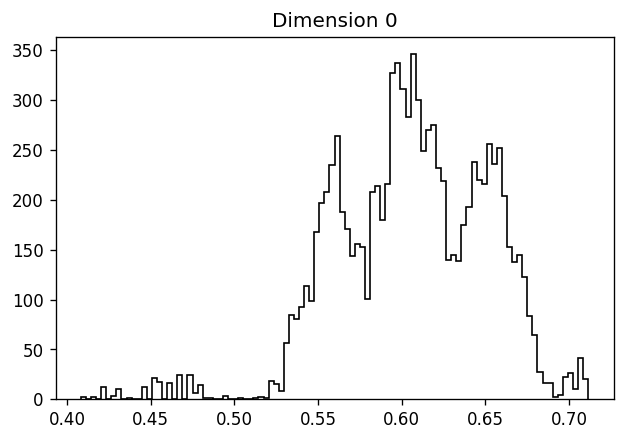

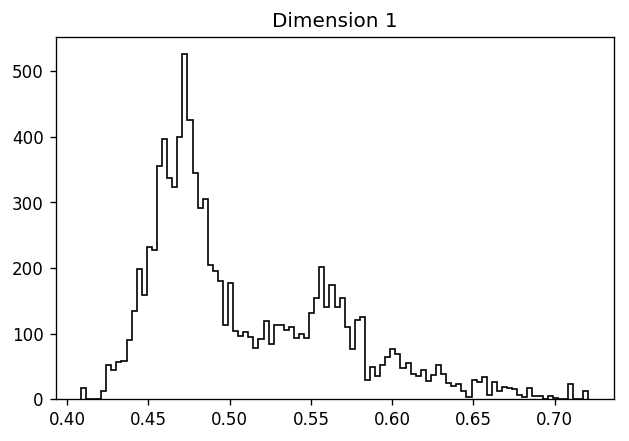

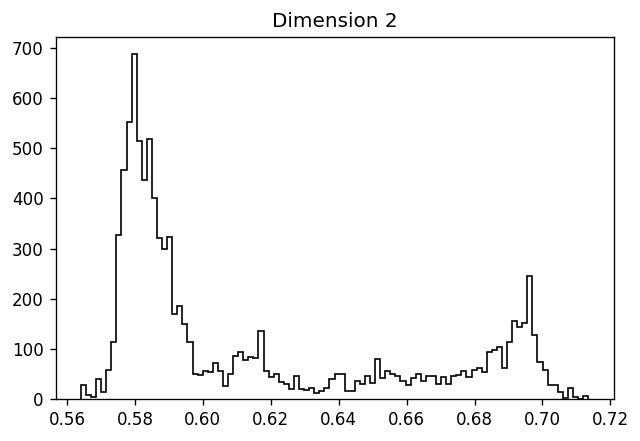

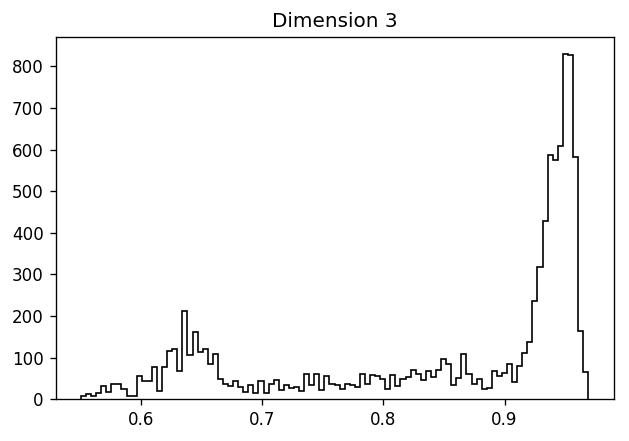

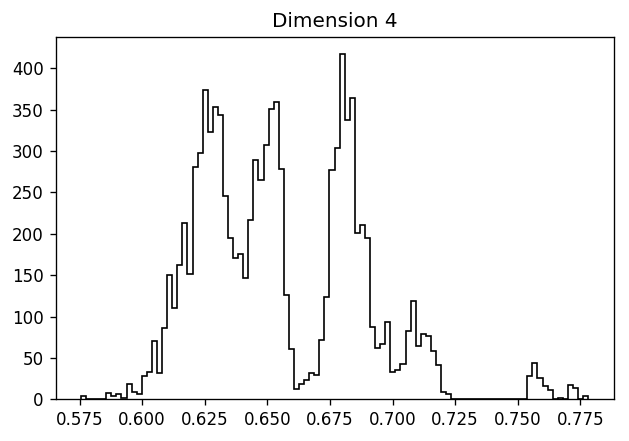

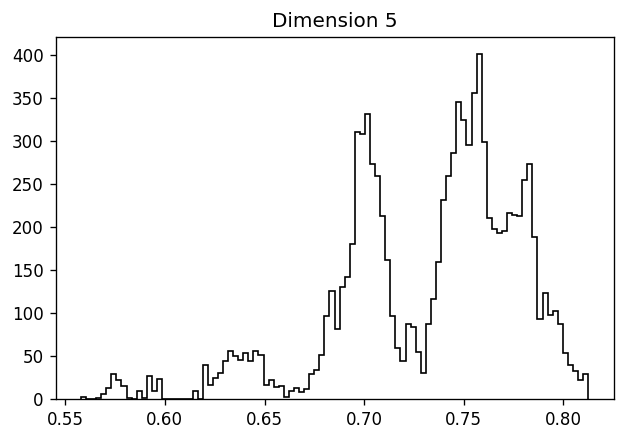

In [16]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.title("Dimension {0:d}".format(i))

In [17]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.372


### Use likelihood object to make several useful plots

In [18]:
for p in like.free_params:
    print(p.name,p.value)

ln_tau_0 -0.870608343976
ln_tau_1 4.1123981589
ln_T0_0 9.57917661083
ln_T0_1 1.65325291385
ln_gamma_0 0.40128929324
ln_gamma_1 0.550678807886


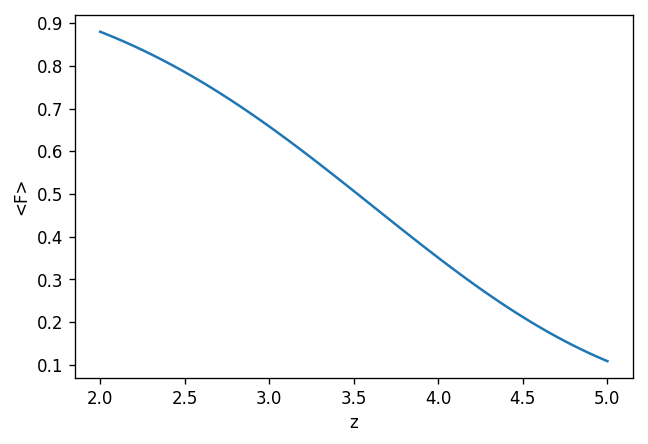

In [19]:
z=np.linspace(2.0,5.0,100)
mf=like.theory.mf_model.get_mean_flux(z)
plt.plot(z,mf)
plt.xlabel('z')
plt.ylabel('<F>')

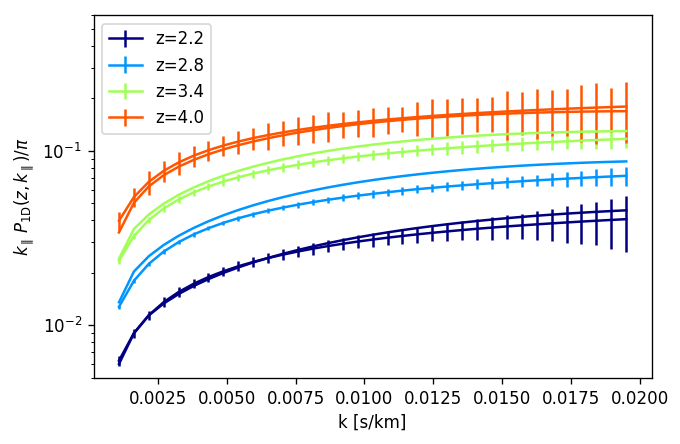

In [20]:
like.plot_p1d()

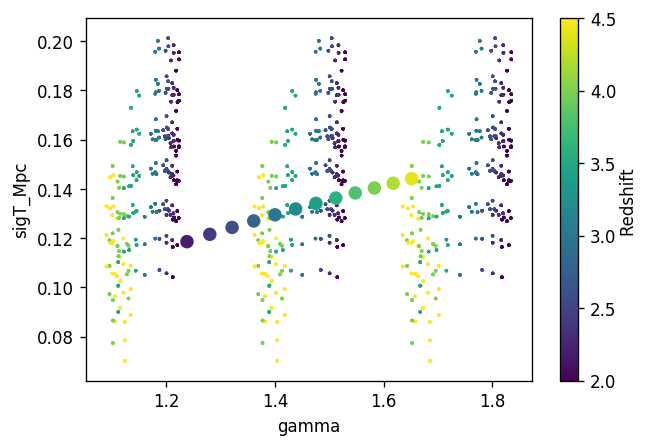

In [21]:
like.overplot_emulator_calls('gamma','sigT_Mpc',linP_Mpc_params=linP_Mpc_params)

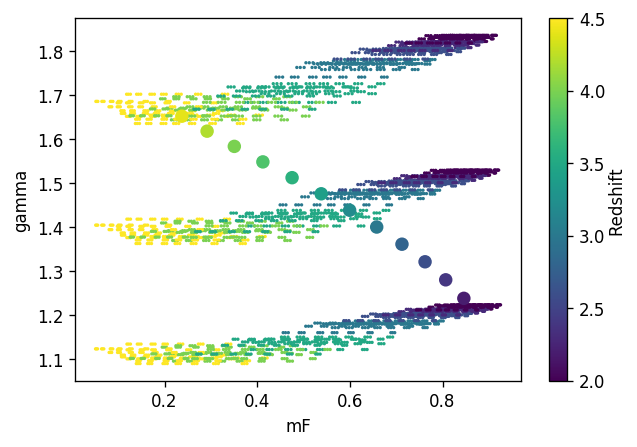

In [22]:
like.overplot_emulator_calls('mF','gamma',linP_Mpc_params=linP_Mpc_params)

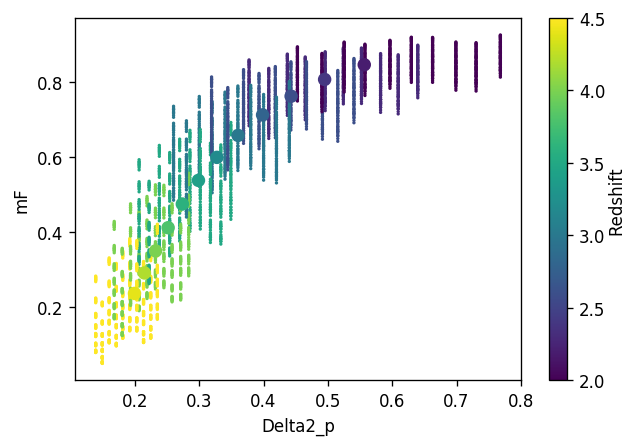

In [23]:
like.overplot_emulator_calls('Delta2_p','mF',linP_Mpc_params=linP_Mpc_params)